# Reproducing Villena-Gonzalez CDA Study (2019) - Cleaning (DELETE ME)


In [1]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events, concatenate_epochs
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum
 
from autoreject import AutoReject

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

Processing: CS230419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/CS230419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 796671  =      0.000 ...   389.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
-------------------

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:112: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/96 [00:00<?,       ?it/s]

Dropped 10 epochs: 0, 33, 36, 50, 60, 66, 67, 84, 86, 94


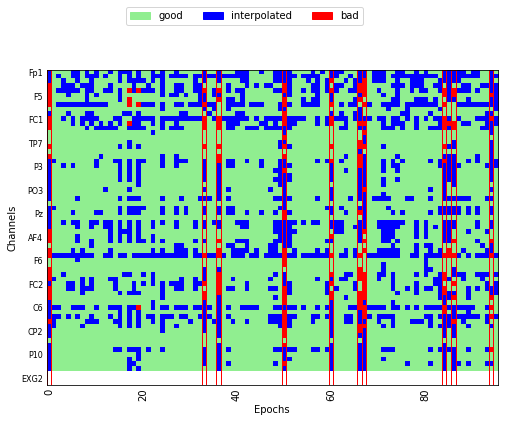

---------- 1-left-good -------------
---------- 1-left-bad -------------
---------- 1-right-good -------------
---------- 1-right-bad -------------
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 1-left-good (15 events vs 14 epochs)
Checksum FAILED! Length mismatch for: 2-left-good (16 events vs 14 epochs)
Checksum FAILED! Length mismatch for: 2-right-good (16 events vs 14 epochs)
Checksum FAILED! Length mismatch for: 4-left-good (15 events vs 13 epochs)
Checksum FAILED! Length mismatch for: 4-right-good (14 events vs 12 epochs)
Checksum FAILED! Length mismatch for: 4-right-bad (2 events vs 1 epochs)


,1,2,4,left,right,good,bad,1-left,1-left-good,1-good,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes
CS230419.bdf,32,32,32,48,48,92,4,16,15,31,...,16,15,29,1,3,16,14,2,0,


In [2]:
#==================================================================
# General Variables
#==================================================================
## Organize Triggers
triggers = dict();

# --------------------------
triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] = [11,12,21,22,41,42]
triggers['right'] = [10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] = [61]

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count


# CDA Channels
chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']

# Epoch information
epoch_length = 1.2
epoch_tmin = -0.4
baseline_corr = (-0.4, -0.2)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
epochs_dict_all = dict()
epochs_dict_clean_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

filepath = directory_path + 'CS230419.bdf'

#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind(sep)+1:]
print('Processing: ' + filename + '...')

# ------------------------
# 1. -- Load File --
# ------------------------
raw = read_raw_bdf(filepath, preload=True)

# ------------------------
# 2. -- Preprocessing --
# ------------------------
# Keep only EEG channels and reference
#raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
raw = raw.drop_channels(ch_names=['EXG7','EXG8','EXG3','EXG4','EXG5','EXG6'])
raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])
raw = raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Resample
preproc = raw.resample(1024)

# Filter
preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

# Events
events = find_events(preproc)

# Plot (visual check)
#preproc.plot(events=events, block=True, lowpass=40)

# ------------------------
# 3. -- Epochs --
# ------------------------
specific_events = get_specific_events(events, conds, sides, perfs, triggers, internal_triggers)

epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=True)

# ------------------------
# 4. - Report & Checksum -
# ------------------------
report = fill_report(report, filename, specific_events)
report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

# ------------------------
# 5 -- CDA --
# ------------------------
cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)
#cda_dict_clean[filename] = get_CDA(epochs_dict_clean, conds, sides, ['good'], chan_right, chan_left)

# Add time points to CDA for later use.
times = epochs_dict['2']['left']['good'].times

# Print report
#subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
report

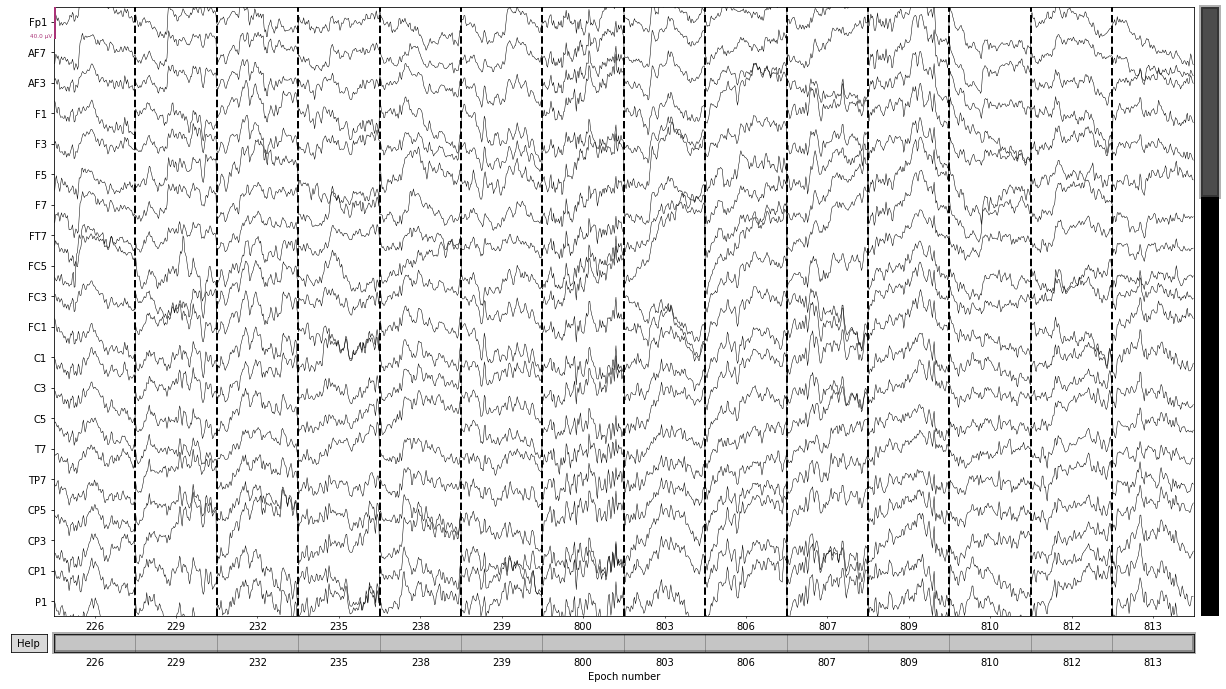

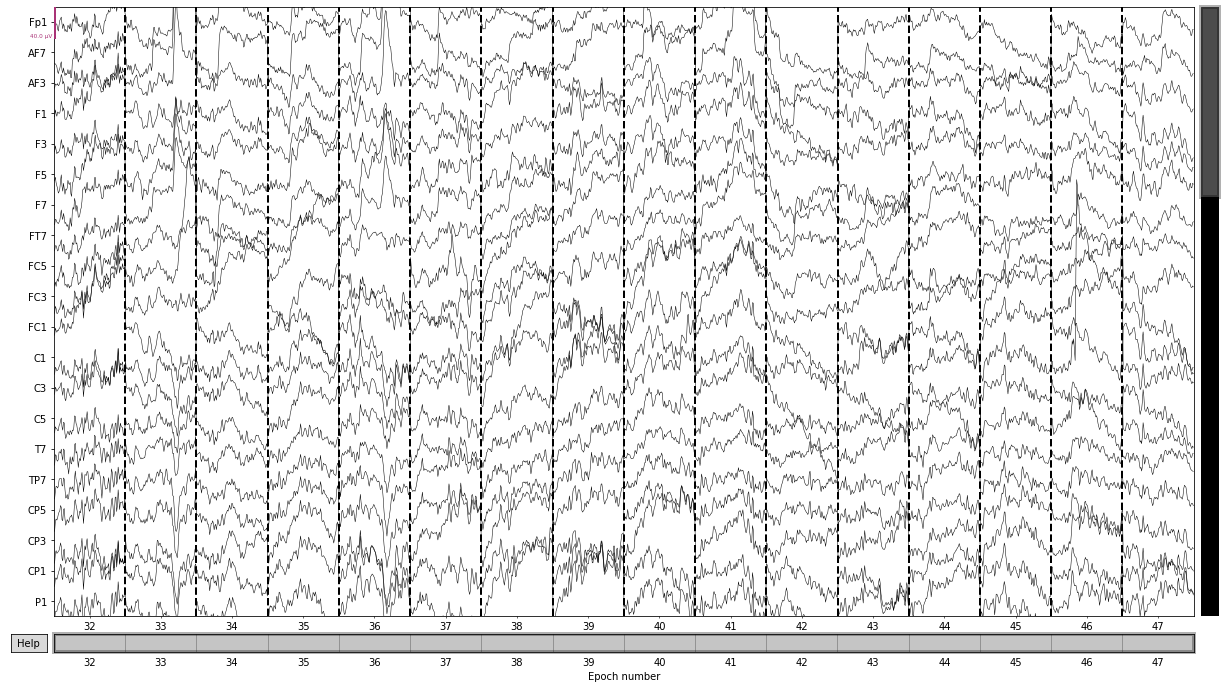

In [11]:
x = epochs_dict_clean['2']['left']['good'].plot()
x = epochs_dict['2']['left']['good'].plot()

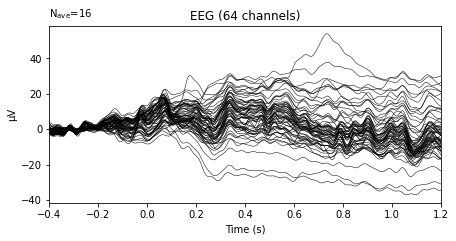

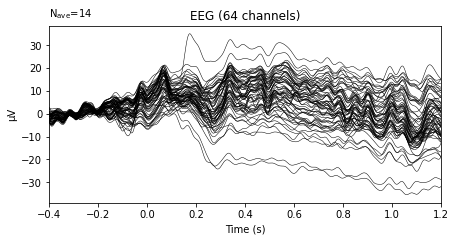

In [21]:
x = epochs_dict['2']['left']['good'].average().plot()
x = epochs_dict_clean['2']['left']['good'].average().plot()

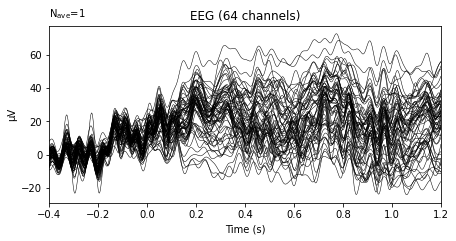

In [12]:
x = epochs_dict['4']['left']['bad'].average().plot()

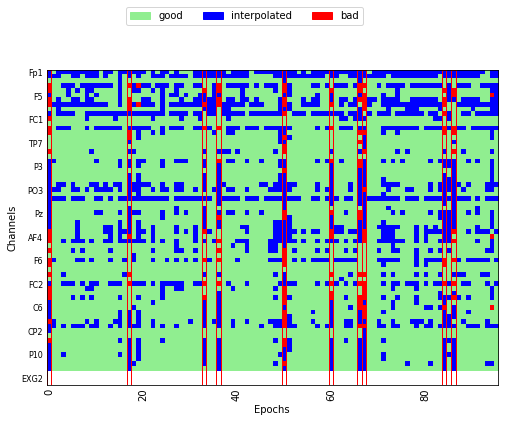

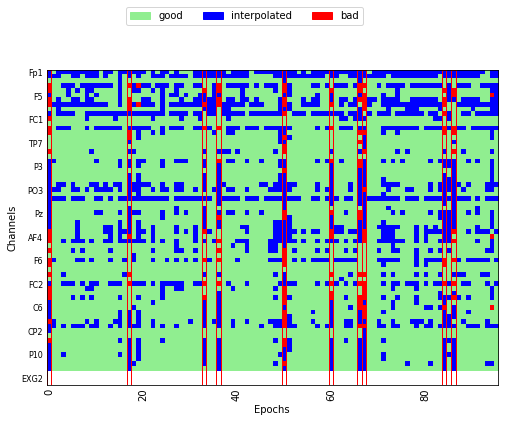

In [16]:
reject_log.plot('horizontal')

Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_46551/102401023.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  x = reject_log.plot_epochs(mne.concatenate_epochs(epochs_to_clean), scalings=scalings)


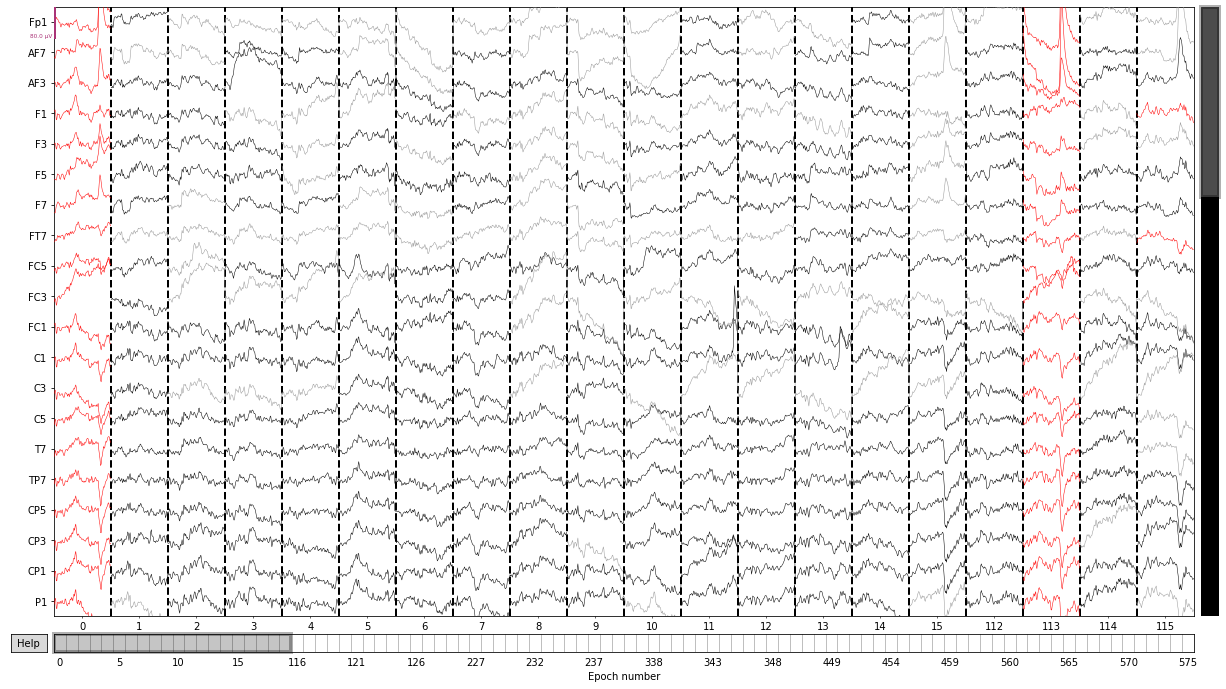

In [20]:
scalings = dict(eeg=40e-6)
x = reject_log.plot_epochs(mne.concatenate_epochs(epochs_to_clean), scalings=scalings)

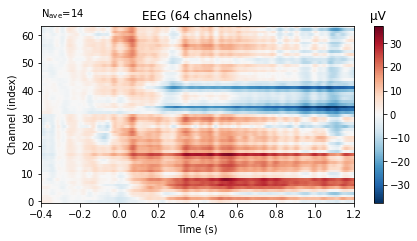

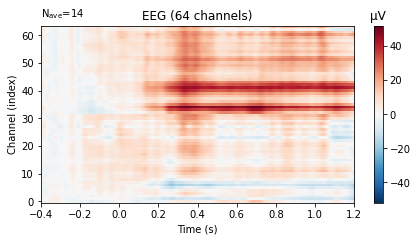

In [8]:
x = epochs_dict_clean['2']['left']['good'].average().plot_image()
x = epochs_dict_clean['2']['right']['good'].average().plot_image()

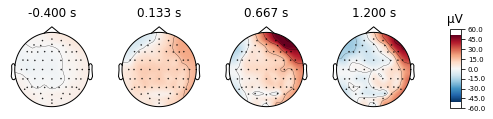

In [10]:
x = epochs_dict_clean['2']['right']['good'].average().plot_topomap()

Text(0.5, 0, '[ms]')

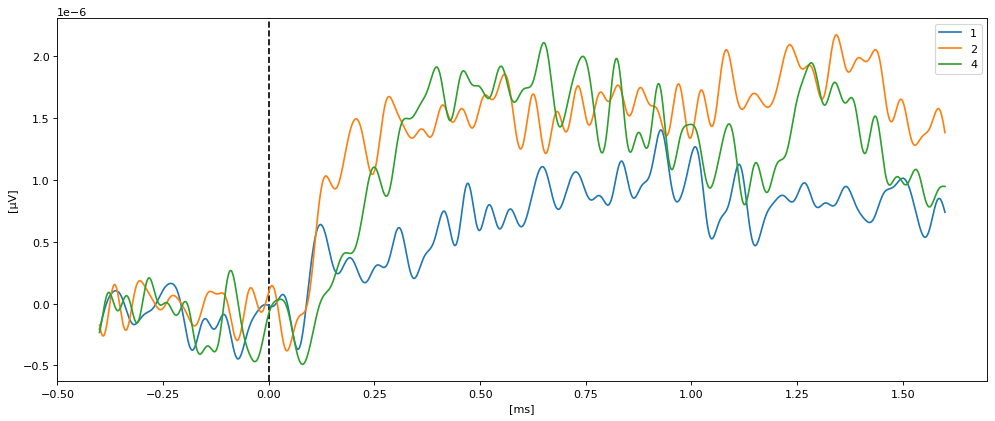

In [9]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        if f == 'ER290419.bdf' and cond == '1':
            continue
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
        
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='1')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['4'].mean(0), label='4')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)